In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
from tensorflow.keras.optimizers import Adam

In [5]:
from sklearn.utils import shuffle

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
import sys

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
sys.path.append('../')

In [10]:
import datatools

In [11]:
import importlib

In [12]:
from glob import glob

In [13]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/stgc/atlas_nsw_pad_z0_stgc20Max1_bkgr_1_CovAngle_TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

135


In [14]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 135/135 [00:02<00:00, 45.08it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 387000/387000 [00:12<00:00, 31419.47it/s]

!!
I read 387000 events, of which 192000 have muon and 195000 do not
!!


In [15]:
import trainingvariables

In [16]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 387000/387000 [00:53<00:00, 7209.36it/s]

Output data matrix shape: (387000, 20, 19)


In [17]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [18]:
X_prep = X_pad

In [19]:
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1

In [20]:
X = X_prep[:,:,vars_of_interest]
X_keys = np.array(sig_keys)[vars_of_interest]

In [21]:
mult_fact = max(data['ev_mu_x'])
mult_facta = max(data['ev_mu_theta'])

In [22]:
data_ev_mu_x = (data['ev_mu_x'])/mult_fact
data_ev_mu_a = (data['ev_mu_theta'])/mult_facta

X_train, Y_clas_train, Y_xreg_train, Y_areg_train = shuffle(X, Y_mu, data_ev_mu_x, data_ev_mu_a)

Y_train = np.zeros( (Y_clas_train.shape[0], 3 ) ) 
Y_train[:,0] = Y_clas_train
Y_train[:,1] = Y_xreg_train
Y_train[:,2] = Y_areg_train

In [23]:
this_cut=(Y_mu==1)

In [24]:
model_loc = '../models/'
model_name = "MyTCN_10,3,1:20,3,1_none_CBNormTrue_DBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten"

In [25]:
keras_model = keras.models.load_model(model_loc+model_name,compile=False)

In [26]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 7)]           0         
_________________________________________________________________
C1D_0 (Conv1D)               (None, 18, 10)            220       
_________________________________________________________________
C1D_1 (Conv1D)               (None, 16, 20)            620       
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
output (Dense)               (None, 3)                 963       
Total params: 1,803
Trainable params: 1,803
Non-trainable params: 0
_________________________________________________________________


In [27]:
all_weights = np.array([])
for layer in keras_model.layers:
    print(layer.name)
    for w in layer.weights:
        all_weights = np.concatenate( [w.numpy().flatten(), all_weights] )
        print (layer.name, w.numpy().shape, np.max(w.numpy().flatten()))

inputs
C1D_0
C1D_0 (3, 7, 10) 0.993133
C1D_0 (10,) 0.6839937
C1D_1
C1D_1 (3, 10, 20) 0.99259216
C1D_1 (20,) 0.21704733
flatten
output
output (320, 3) 0.54816276
output (3,) 0.9999999


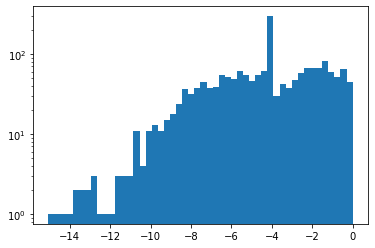

In [28]:
plt.Figure()
plt.hist( np.log2(np.abs(all_weights+1e-100)), bins=50 )
plt.yscale('log')
plt.show()

In [29]:
keras_model.layers[1].weights[1].numpy().flatten()

array([-0.03582856, -0.01221315,  0.6839937 , -0.09065782,  0.12878466,
       -0.02241887,  0.1725231 ,  0.0119364 , -0.1340008 , -0.08448809],
      dtype=float32)

In [30]:
keras_preds = keras_model.predict(X, batch_size=1024)

In [31]:
keras_yhat = sigmoid(keras_preds[:,0])

In [32]:
keras_x_reg = keras_preds[:,1]*mult_fact
keras_a_reg = keras_preds[:,2]*mult_facta

In [33]:
keras_mod_msex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], keras_x_reg[this_cut] )
keras_mod_msea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], keras_a_reg[this_cut] )
keras_mod_auc = metrics.roc_auc_score( Y_mu, keras_yhat )
keras_fpr, keras_tpr, keras_thresholds = metrics.roc_curve( Y_mu, keras_yhat )
print(keras_mod_msex, keras_mod_msea, keras_mod_auc)

1.1507068668597131 1.618206251107799e-05 0.9990656407986112


## Pruning

In [34]:
import tensorflow_model_optimization as tfmot

In [35]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [36]:
# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

In [37]:
num_images = X.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

In [38]:
import mlmodels

In [39]:
import tempfile

In [40]:
combloss = mlmodels.class_and_regr_loss(1,
                                   do_angle=1, 
                                   pen_type=2, pen_x=True, pen_a=True, bkg_pen_x=False, bkg_pen_a=False, linearized=True)

In [41]:
initial_sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
final_sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pruned_mod_msex_s = []
pruned_mod_msea_s = []
pruned_mod_auc_s = []

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 3s 38ms/step - loss: 0.2371 - val_loss: 0.2365
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2579 - val_loss: 0.2426
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2370 - val_loss: 0.3635
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2543 - val_loss: 0.2996
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.3113 - val_loss: 0.3154
1.1522566912300685 2.6387740449392386e-05 0.9990608400774571


<ipython-input-42-bbc3dd4f63f3>:67: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-42-bbc3dd4f63f3>:68: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


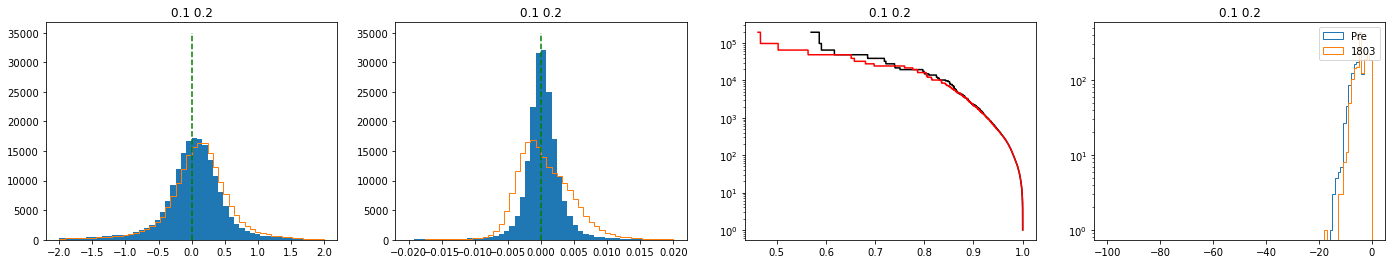

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 2s 41ms/step - loss: 0.3198 - val_loss: 0.3119
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2726 - val_loss: 0.2468
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2290 - val_loss: 0.2478
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2442 - val_loss: 0.2283
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2146 - val_loss: 0.2281
1.3625403249265846 1.8017111749303937e-05 0.9991076554620727


<ipython-input-42-bbc3dd4f63f3>:67: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-42-bbc3dd4f63f3>:68: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


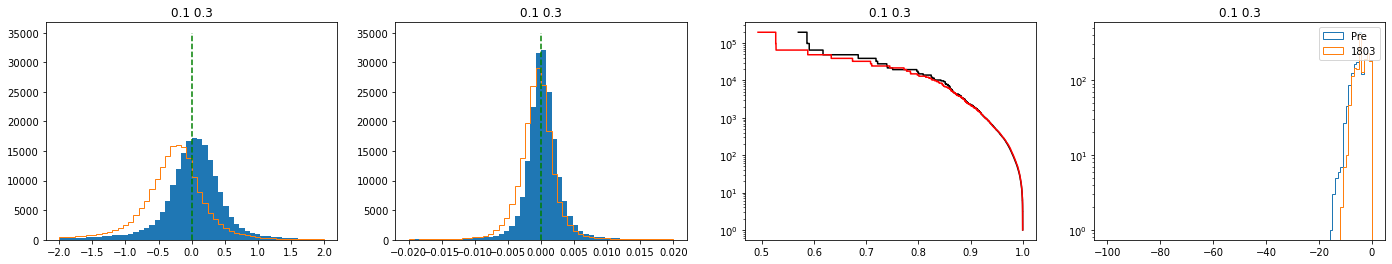

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 2s 43ms/step - loss: 0.3354 - val_loss: 0.2746
Epoch 2/5
22/22 [==============================] - 1s 28ms/step - loss: 0.2717 - val_loss: 0.2642
Epoch 3/5
22/22 [==============================] - 1s 29ms/step - loss: 0.2371 - val_loss: 0.1993
Epoch 4/5
22/22 [==============================] - 1s 28ms/step - loss: 0.2211 - val_loss: 0.2073
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2257 - val_loss: 0.2583
1.2249375523550377 1.9356582196056886e-05 0.9990896549946582


<ipython-input-42-bbc3dd4f63f3>:67: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-42-bbc3dd4f63f3>:68: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


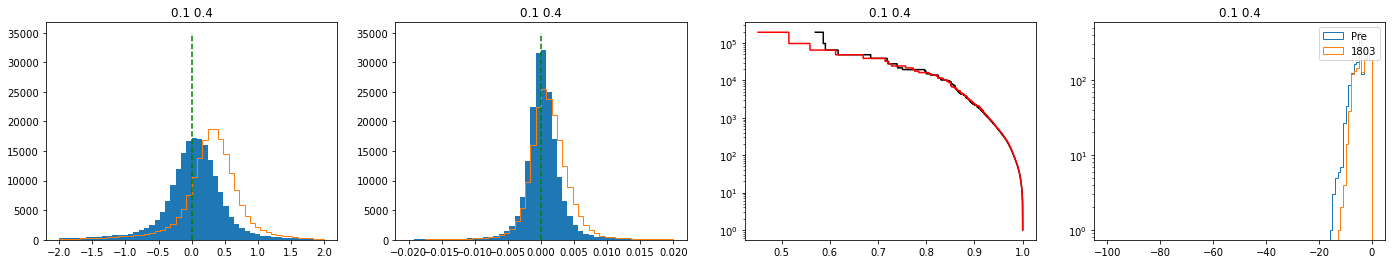

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 2s 41ms/step - loss: 0.2905 - val_loss: 0.2544
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2488 - val_loss: 0.2349
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2243 - val_loss: 0.2498
Epoch 4/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2381 - val_loss: 0.2527
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2395 - val_loss: 0.2174
1.261491444053231 1.901224718254673e-05 0.9991006825454061


<ipython-input-42-bbc3dd4f63f3>:67: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-42-bbc3dd4f63f3>:68: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


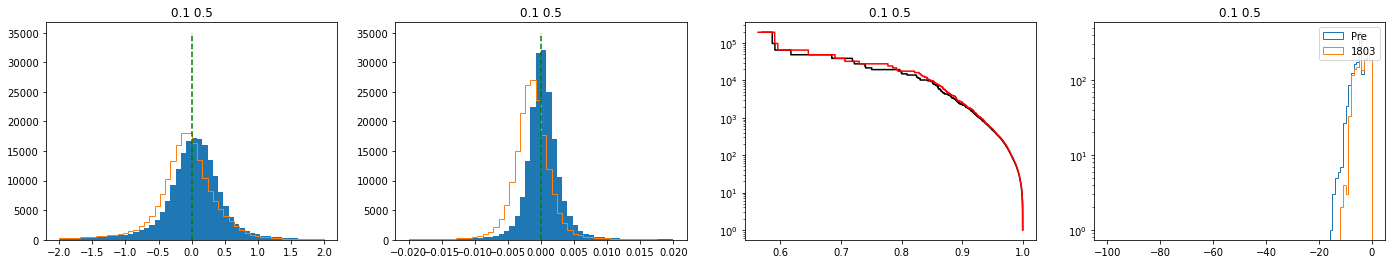

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 2s 41ms/step - loss: 0.2485 - val_loss: 0.2520
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2447 - val_loss: 0.2977
Epoch 3/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2535 - val_loss: 0.2470
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2463 - val_loss: 0.2424
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.2264 - val_loss: 0.2511
1.2185477066548274 1.973526774376273e-05 0.9990995840277777


<ipython-input-42-bbc3dd4f63f3>:67: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-42-bbc3dd4f63f3>:68: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


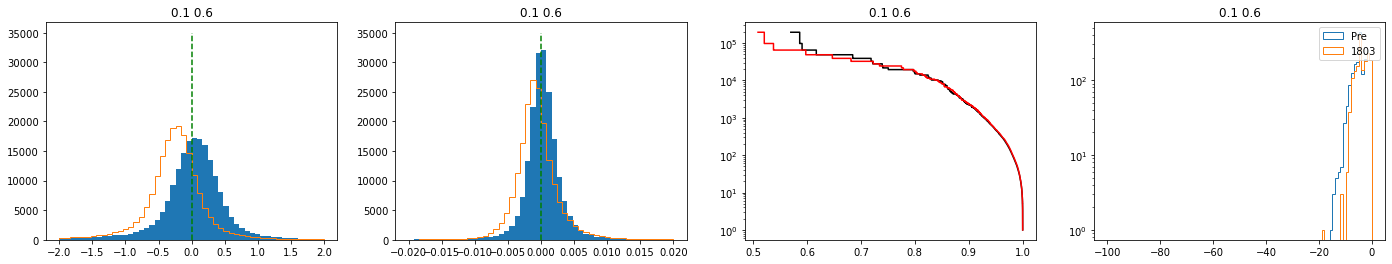

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/5
22/22 [==============================] - 2s 50ms/step - loss: 0.2511 - val_loss: 0.3328
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.2897 - val_loss: 0.3209
Epoch 3/5
22/22 [==============================] - 1s 28ms/step - loss: 0.3236 - val_loss: 0.2467
Epoch 4/5
 7/22 [========>.....................] - ETA: 0s - loss: 0.2175

In [ ]:
for isp in initial_sparsities:
    for fsp in final_sparsities:
        
        if fsp <= isp: continue

        pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=isp,
                                                                       final_sparsity=fsp,
                                                                       begin_step=0,
                                                                       end_step=end_step)
        }

        model_for_pruning = prune_low_magnitude(keras_model, **pruning_params)

        # `prune_low_magnitude` requires a recompile.
        model_for_pruning.compile(optimizer='adam',
                      loss=combloss)

        logdir = tempfile.mkdtemp()

        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep(),
          tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        model_for_pruning.fit(X_train, Y_train,
                          batch_size=batch_size**2, epochs=5, validation_split=validation_split,
                          callbacks=callbacks)
        
        model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
        
        pruned_weights = np.array([])
        n_weights = 0
        for layer in model_for_export.layers:
            for w in layer.weights:
                pruned_weights = np.concatenate( [w.numpy().flatten(), pruned_weights] )
                n_weights += w.numpy().flatten().shape[0]

        pruned_preds = model_for_export.predict(X, batch_size=1024)
        pruned_yhat = sigmoid(pruned_preds[:,0])
        pruned_x_reg = pruned_preds[:,1]*mult_fact
        pruned_a_reg = pruned_preds[:,2]*mult_facta
        
        
        tmsex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], pruned_x_reg[this_cut] )
        tmsea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], pruned_a_reg[this_cut] )
        tauc = metrics.roc_auc_score( Y_mu, pruned_yhat )
        tfpr, ttpr, _ = metrics.roc_curve( Y_mu, pruned_yhat )
        print(tmsex, tmsea, tauc)
        
        pruned_mod_msex_s.append(tmsex)
        pruned_mod_msea_s.append(tmsea)
        pruned_mod_auc_s.append(tauc)
        
        ncols, nrows = (4,1)
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
        axs = axs.flatten()
        
        axs[0].hist( keras_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='stepfilled', bins=50, range=(-2,2) )
        axs[0].hist( pruned_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='step', bins=50, range=(-2,2) )
        axs[0].plot( [0,0], [0,35000], 'g--' )
        
        axs[1].hist( keras_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='stepfilled', bins=50, range=(-0.02,0.02) )
        axs[1].hist( pruned_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='step', bins=50, range=(-0.02,0.02) )
        axs[1].plot( [0,0], [0,35000], 'g--' )
        
        axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
        axs[2].semilogy( ttpr, 1./tfpr, color='red' )
        
        axs[3].hist( np.log2(np.abs(all_weights+1e-100)), histtype='step', bins=100, range=(-100,0), label="Pre" )
        axs[3].hist( np.log2(np.abs(pruned_weights+1e-100)), histtype='step', bins=100, range=(-100,0), label=f"{n_weights}" )
        axs[3].set_yscale('log')
        axs[3].legend()
        
        for ax in axs:
            ax.set_title(f"{isp} {fsp}")
        
        plt.show()